In [1]:
from os import listdir
from sklearn import preprocessing
import matplotlib.image as image
import numpy as np

In [2]:
def loadImages(path):
    # return array of images

    labledDataSet = np.empty((1, 10305))
    personList = listdir(path)
    
    for person in personList:
        imgList = listdir(path + "/" + person)
        
        for img in imgList:
            anImage = image.imread(path + "/" + person + "/" + img)
            #print(path + "/" + person + "==>" + img)
            label = [person]
            anImage = anImage.flatten()
            labledSample = np.concatenate((label, anImage))
            labledSample = labledSample.reshape(1, 10305)
            labledDataSet = np.append(labledDataSet, labledSample, 0)
    
    labledDataSet = labledDataSet[1:,:]
    return labledDataSet


In [3]:
path = "att_faces/orl_faces"

#load the dataset
labeledData = loadImages(path)

#split the dataset
trainingLabeledData = labeledData[1::2]
testLabeledData = labeledData[0::2]

#split the labels from the data
trainingLabels, trainingData = trainingLabeledData[:,0], trainingLabeledData[:,1:]
trainingData = np.array(trainingData).astype(np.float64)

#scale the training data
scaledTrainingData = preprocessing.scale(trainingData)

#provide an access to each label
trainingDict = {trainingLabel: trainingData[trainingLabels == trainingLabel] for trainingLabel in np.unique(trainingLabels)}

testLabels, testData = testLabeledData[:,0], testLabeledData[:,1:]
testData = np.array(testData).astype(np.float64)

#scale the test data
scaledTestData = preprocessing.scale(testData)

#provide an access to each label
testDict = {testLabel: testData[testLabels == testLabel] for testLabel in np.unique(testLabels)}

# Linear Discriminant Analysis

In [4]:
#calculate the required means (the total mean should be close to zero)
totalMean = np.matrix(np.mean(scaledTrainingData, axis = 0))

classMeans = dict()

for label, labelData in trainingDict.items():
    classMeans[label] = np.matrix(np.mean(labelData, axis = 0))



In [5]:
#calculate the between-class matrix Sb and the within-class matrix Sw 
Sb = np.zeros((10304, 10304))
Sw = np.zeros((10304, 10304))

for label, classMean in classMeans.items():
    diffBetween = classMean - totalMean
    Sb += np.ma.size(trainingDict[label], 0) * np.dot(diffBetween.T, diffBetween)
    
    diffWithin = trainingDict[label] - classMean
    Sw += np.dot(diffWithin.T, diffWithin)

In [6]:
#calculate the pseudoinverse of Sw then SwPinv . Sb
SwPinv = np.linalg.pinv(Sw)
x = np.dot(SwPinv, Sb)

In [7]:
#calculate the eigen vectors of SwPinv . Sb
[eigenVals, eigenVects] = np.linalg.eig(x)

idx = np.argsort(eigenVals)
idx = np.flip(idx)
eigenVals = eigenVals[idx]
eigenVects = eigenVects[:, idx]

In [8]:
realEigenVals = eigenVals.real
realEigenVects = eigenVects.real
print("error distance for eigen values if we ommit the complex part")
print(np.linalg.norm(eigenVals - realEigenVals))


error distance for eigen values if we ommit the complex part
0.22764755425863617


# Nearest Neighbor for Linear Discriminant Analysis

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score  

#project the training data
topK = realEigenVects[:, :39]
projectedTrainingData = np.dot(trainingData, topK)

#project the test data
projectedTestData = np.dot(testData, topK)

#train the classifier
classifier = KNeighborsClassifier(n_neighbors = 1)
classifierThree = KNeighborsClassifier(n_neighbors = 3)
classifierFive = KNeighborsClassifier(n_neighbors = 5)
classifierSeven = KNeighborsClassifier(n_neighbors = 7)

classifier.fit(projectedTrainingData, trainingLabels)
classifierThree.fit(projectedTrainingData, trainingLabels) 
classifierFive.fit(projectedTrainingData, trainingLabels) 
classifierSeven.fit(projectedTrainingData, trainingLabels) 

#predict
labelPredict = classifier.predict(projectedTestData)
labelPredictThree = classifierThree.predict(projectedTestData)
labelPredictFive = classifierFive.predict(projectedTestData)
labelPredictSeven = classifierSeven.predict(projectedTestData)

#evaluation
print("One nearest neighbor")
print(confusion_matrix(testLabels, labelPredict))  
print(classification_report(testLabels, labelPredict))
print("accuracy score")
accuracyOne = accuracy_score(testLabels, labelPredict)
print(accuracyOne)
print("============================================================")
print("Three nearest neighbors")
print(confusion_matrix(testLabels, labelPredictThree))  
print(classification_report(testLabels, labelPredictThree))
print("accuracy score")
accuracyThree = accuracy_score(testLabels, labelPredictThree)
print(accuracyThree)
print("============================================================")
print("Five nearest neighbors")
print(confusion_matrix(testLabels, labelPredictFive))  
print(classification_report(testLabels, labelPredictFive))
print("accuracy score")
accuracyFive = accuracy_score(testLabels, labelPredictFive)
print(accuracyFive)
print("============================================================")
print("Seven nearest neighbors")
print(confusion_matrix(testLabels, labelPredictSeven))  
print(classification_report(testLabels, labelPredictSeven))
print("accuracy score")
accuracySeven = accuracy_score(testLabels, labelPredictSeven)
print(accuracySeven)

One nearest neighbor
[[3 0 0 ... 0 0 0]
 [0 5 0 ... 0 0 0]
 [0 0 5 ... 0 0 0]
 ...
 [0 0 0 ... 5 0 0]
 [0 0 0 ... 0 5 0]
 [0 0 0 ... 0 0 5]]
              precision    recall  f1-score   support

          s1       1.00      0.60      0.75         5
         s10       1.00      1.00      1.00         5
         s11       1.00      1.00      1.00         5
         s12       1.00      1.00      1.00         5
         s13       0.83      1.00      0.91         5
         s14       1.00      1.00      1.00         5
         s15       1.00      1.00      1.00         5
         s16       1.00      0.80      0.89         5
         s17       0.71      1.00      0.83         5
         s18       1.00      0.60      0.75         5
         s19       1.00      1.00      1.00         5
          s2       0.83      1.00      0.91         5
         s20       1.00      0.80      0.89         5
         s21       1.00      1.00      1.00         5
         s22       0.83      1.00      0.91     

D:\Tools\Anaconda\envs\my-env\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


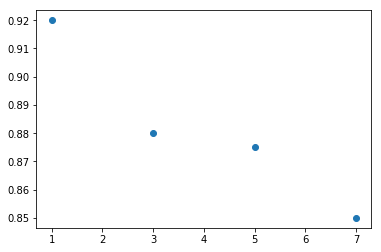

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
xline = [1, 3, 5, 7]
yline = [accuracyOne, accuracyThree, accuracyFive, accuracySeven]
plt.plot(xline, yline, "o")

## bonus


In [11]:
dataSetDic = {label: labeledData[labeledData[:,0] == label][:,1:] for label in np.unique(labeledData[:,0])}
y_test = np.empty((2,1))
y_train= np.empty((2,1))
x_train = np.empty((1,10304))
x_test = np.empty((1,10304))

In [12]:
for i in range(41):
    
    if(i != 0):
        label = 's'+str(i)
        x_train = np.vstack((x_train,dataSetDic[label][0:7,:]))
        x_test = np.vstack((x_test,dataSetDic[label][7:,:]))
        
        for count in range(7):
            y_train = np.vstack((y_train,[label]))
            
        for index in range(3):
            y_test = np.vstack((y_test,[label]))

y_train = y_train[2: , :]
x_train = x_train[1: , :]
x_train = x_train.astype(float)
x_trainDict = {label: x_train[y_train.reshape(280,) == label] for label in np.unique(y_train)}



y_test = y_test[2: , :]
x_test= x_test[1: , :]
x_test = x_test.astype(float)
print(x_test.shape)
x_testDict = {test_label:x_test[y_test.reshape(120,)==test_label] for test_label in np.unique(y_test)}

print(x_train.shape)
print(x_test.shape)


print(y_train.shape)
print(y_test.shape)

(120, 10304)
(280, 10304)
(120, 10304)
(280, 1)
(120, 1)


In [13]:
#total mean of all classes
totalMean = np.matrix(np.mean(x_train,0))
print(totalMean.shape)
#mean for each class
classMean = dict()
for label, data in x_trainDict.items():
    classMean[label] = np.matrix(np.mean(data,0))

(1, 10304)


In [14]:
Sb = np.zeros((10304,10304))
Sw = np.zeros((10304,10304))

for label, calss_mean in classMean.items():
    diff = calss_mean - totalMean
    Sb += x_trainDict[label].size * np.dot(diff.T,diff)
    
    diffWithin = x_trainDict[label] - calss_mean
    Sw += np.dot(diffWithin.T, diffWithin)
    

In [15]:
#Get inverse of within matrix
SwPinv = np.linalg.pinv(Sw)
S =np.dot(SwPinv, Sb)

In [16]:
#Get eigenVectors and eigenValues of S
eigenValues_b, eigenVectors_b = np.linalg.eig(S)

#descending order
idx = np.argsort(eigenValues_b)[::-1]
eigenVectors_b = eigenVectors_b[:,idx]
 # sort eigenvectors according to same index
eigenValues_b = eigenValues_b[idx]

realEigenVals_b = eigenValues_b.real
realEigenVects_b = eigenVectors_b.real



## prediction

In [17]:
#Classification using K-NN

reduced_realEigenVects_b = realEigenVects_b[:, 0:39]
projected_trainingSet = np.dot(x_train, reduced_realEigenVects_b)
projected_testingSet = np.dot(x_test, reduced_realEigenVects_b)

classifer_b = KNeighborsClassifier(n_neighbors= 1)
classifer_b.fit(projected_trainingSet, y_train)

prediction = classifer_b.predict(projected_testingSet)
accuracy = accuracy_score(prediction, y_test)

print(accuracy)

0.8916666666666667


D:\Tools\Anaconda\envs\my-env\lib\site-packages\ipykernel_launcher.py:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  
